<a href="https://colab.research.google.com/github/Chandrashekar0123/Lerno-DL-case-study/blob/MonkeyPox-detection/OwnModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to your dataset
data_dir = '/content/drive/MyDrive/Original Images/Original Images'

# Create an image data generator with data augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,  # Increased rotation range
    width_shift_range=0.3,  # Increased width shift
    height_shift_range=0.3,  # Increased height shift
    shear_range=0.3,  # Increased shear range
    zoom_range=0.3,  # Increased zoom range
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the data for validation
)

# Create training and validation generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Define the custom CNN model using Functional API
def create_model():
    inputs = layers.Input(shape=(224, 224, 3))

    # 1. Convo, Convo, Convo, Pooling
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # 2. Convo, Convo, Pooling
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Parallel execution of Convo, Convo, Pooling and Convo, Convo, Pooling
    # Set 1
    conv_set_1 = layers.Conv2D(128, (3, 3), activation='relu')(x)
    conv_set_1 = layers.BatchNormalization()(conv_set_1)
    conv_set_1 = layers.Conv2D(128, (3, 3), activation='relu')(conv_set_1)
    conv_set_1 = layers.MaxPooling2D((2, 2))(conv_set_1)

    # Set 2
    conv_set_2 = layers.Conv2D(128, (3, 3), activation='relu')(x)
    conv_set_2 = layers.BatchNormalization()(conv_set_2)
    conv_set_2 = layers.Conv2D(128, (3, 3), activation='relu')(conv_set_2)
    conv_set_2 = layers.MaxPooling2D((2, 2))(conv_set_2)

    # Combine both sets
    combined = layers.Concatenate()([conv_set_1, conv_set_2])

    # 3. Convo, Convo, Pooling (after combining sets)
    x = layers.Conv2D(128, (3, 3), activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convo, Pooling
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)


    # 4. Flattening
    x = layers.Flatten()(x)

    # 5. Dense Layers
    x = layers.Dense(256, activation='relu')(x)  # Increased nodes
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer for binary classification
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# Create the model
model = create_model()

# Compile the model with a learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

Found 183 images belonging to 2 classes.
Found 45 images belonging to 2 classes.


In [ ]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 222, 222, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 222, 222, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 220, 220, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 220, 220, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 218, 218, 32)   │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 109, 109, 32)   │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 107, 107, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 107, 107, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 105, 105, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 52, 52, 64)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 50, 50, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 50, 50, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 50, 50, 128)    │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 50, 50, 128)    │            512 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 48, 48, 128)    │        147,584 │ batch_normalization_3… │
├──────────────────────

 Total params: 1,676,225 (6.39 MB)

 Trainable params: 1,674,945 (6.39 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:

# Train the model
history = model.fit(
    train_generator,
    epochs=30,  # You can adjust epochs as necessary
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 146s 22s/step - accuracy: 0.5295 - loss: 1.0896 - val_accuracy: 0.5556 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 125s 19s/step - accuracy: 0.5764 - loss: 1.0867 - val_accuracy: 0.5556 - val_loss: 0.6884 - learning_rate: 0.0010
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 117s 19s/step - accuracy: 0.6644 - loss: 0.7835 - val_accuracy: 0.5556 - val_loss: 0.6847 - learning_rate: 0.0010
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 116s 19s/step - accuracy: 0.5368 - loss: 1.0116 - val_accuracy: 0.5556 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 141s 19s/step - accuracy: 0.6136 - loss: 0.9643 - val_accuracy: 0.5556 - val_loss: 0.6738 - learning_rate: 0.0010
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 115s 19s/step - accuracy: 0.5212 - loss: 1.3232 - val_accuracy: 0.5556 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 123s 20s/step - accuracy: 0.6801 - loss: 0.8275 - val_accuracy: 0.5556 - va

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation loss: {loss}, Validation accuracy: {accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4954 - loss: 0.7222
Validation loss: 0.7003380060195923, Validation accuracy: 0.5555555820465088


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/Original Images/Original Images/Monkey Pox"))


['M42_01.jpg', 'M23_01.jpg', 'M43_01.jpg', 'M48_03.jpg', 'M48_02.jpg', 'M14_01.jpg', 'M52_01.jpg', 'M20_01.jpg', 'M43_03.jpg', 'M39_01.jpg', 'M20_02.jpg', 'M17_02.jpg', 'M31_02.jpg', 'M33_01.jpg', 'M47_01.jpg', 'M34_01.jpg', 'M19_01.jpg', 'M40_01.jpg', 'M02_02.jpg', 'M49_01.jpg', 'M28_02.jpg', 'M17_01.jpg', 'M09_03.jpg', 'M06_02.jpg', 'M26_02.jpg', 'M06_01.jpg', 'M55_01.jpg', 'M45_01.jpg', 'M49_03.jpg', 'M33_02.jpg', 'M07_01.jpg', 'M46_02.jpg', 'M18_02.jpg', 'M51_01.jpg', 'M09_01.jpg', 'M01_01.jpg', 'M21_02.jpg', 'M35_01.jpg', 'M08_01.jpg', 'M19_02.jpg', 'M32_04.jpg', 'M28_01.jpg', 'M26_01.jpg', 'M48_01.jpg', 'M36_01.jpg', 'M30_01.jpg', 'M50_02.jpg', 'M53_01.jpg', 'M46_01.jpg', 'M18_01.jpg', 'M54_01.jpg', 'M10_02.jpg', 'M02_01.jpg', 'M16_01.jpg', 'M05_01.jpg', 'M28_04.jpg', 'M34_04.jpg', 'M01_04.jpg', 'M29_01.jpg', 'M35_02.jpg', 'M50_03.jpg', 'M24_02.jpg', 'M31_01.jpg', 'M34_02.jpg', 'M15_01.jpg', 'M21_01.jpg', 'M30_02.jpg', 'M11_01.jpg', 'M43_02.jpg', 'M34_03.jpg', 'M10_01.jpg', 'M49_

In [ ]:

print(os.listdir("/content/drive/MyDrive/Original Images/Original Images/Others"))

['NM56_02.jpg', 'NM98_02.jpg', 'NM82_01.jpg', 'NM100_01.jpg', 'NM76_01.jpg', 'NM29_01.jpg', 'NM53_01.jpg', 'NM45_02.jpg', 'NM14_01.jpg', 'NM43_02.jpg', 'NM99_02.jpg', 'NM91_02.jpg', 'NM45_01.jpg', 'NM57_01.jpg', 'NM31_01.jpg', 'NM55_01.jpg', 'NM81_01.jpg', 'NM39_01.jpg', 'NM41_01.jpg', 'NM83_01.jpg', 'NM49_01.jpg', 'NM24_01.jpg', 'NM21_01.jpg', 'NM96_01.jpg', 'NM109_01.jpg', 'NM33_02.jpg', 'NM43_03.jpg', 'NM43_04.jpg', 'NM101_02.jpg', 'NM107_01.jpg', 'NM89_01.jpg', 'NM09_01.jpg', 'NM77_01.jpg', 'NM03_01.jpg', 'NM56_01.jpg', 'NM37_01.jpg', 'NM75_01.jpg', 'NM12_01.jpg', 'NM73_01.jpg', 'NM98_01.jpg', 'NM19_01.jpg', 'NM65_01.jpg', 'NM80_01.jpg', 'NM44_01.jpg', 'NM05_01.jpg', 'NM110_01.jpg', 'NM63_01.jpg', 'NM67_01.jpg', 'NM11_01.jpg', 'NM102_01.jpg', 'NM54_01.jpg', 'NM13_01.jpg', 'NM43_05.jpg', 'NM18_01.jpg', 'NM35_01.jpg', 'NM84_01.jpg', 'NM07_01.jpg', 'NM15_02.jpg', 'NM90_01.jpg', 'NM69_01.jpg', 'NM02_01.jpg', 'NM104_01.jpg', 'NM55_02.jpg', 'NM93_01.jpg', 'NM23_01.jpg', 'NM108_01.jpg', '

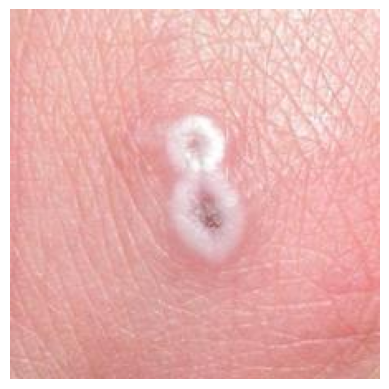

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Predicted class: Monkeypox
Actual class: Monkey Pox
Path parts: ['', 'content', 'drive', 'MyDrive', 'Original Images', 'Original Images', 'Monkey Pox', 'M23_01.jpg']


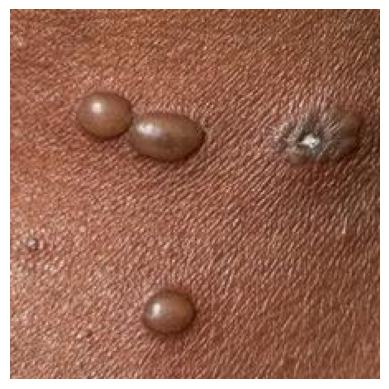

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Predicted class: Monkeypox
Actual class: Others
Path parts: ['', 'content', 'drive', 'MyDrive', 'Original Images', 'Original Images', 'Others', 'NM76_01.jpg']


'Monkeypox'

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import os  # To handle paths

def predict_image(image_path):
    # Load the image with target size
    img = load_img(image_path, target_size=(224, 224))  # Adjust target_size if needed
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()

    # Preprocess the image
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)  # Reshape for the model
    x = x / 255.0  # Normalize the image if needed by your model

    # Make the prediction
    prediction = model.predict(x)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(prediction, axis=1)[0]

    # Define class names based on the model's output layer
    class_names = ['Monkeypox', 'Other']

    # Get the name of the predicted class
    predicted_class_name = class_names[predicted_class_index]

    # Extract the actual class from the folder name (assuming class names are folder names)
    actual_class_name = os.path.basename(os.path.dirname(image_path))

    # Print the predicted and actual class names
    print(f"Predicted class: {predicted_class_name}")
    print(f"Actual class: {actual_class_name}")
    print("Path parts:", image_path.split('/'))

    return predicted_class_name

# Test the function with the provided paths
predict_image("/content/drive/MyDrive/Original Images/Original Images/Monkey Pox/M23_01.jpg")
predict_image("/content/drive/MyDrive/Original Images/Original Images/Others/NM76_01.jpg")


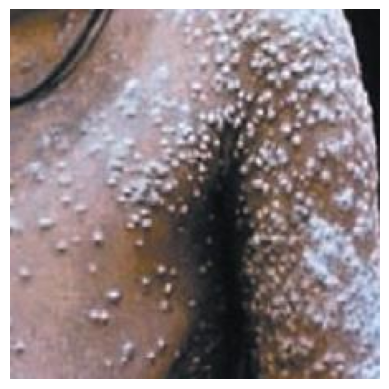

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Predicted class: Monkeypox
Actual class: Monkey Pox
Path parts: ['', 'content', 'drive', 'MyDrive', 'Original Images', 'Original Images', 'Monkey Pox', 'M26_01.jpg']


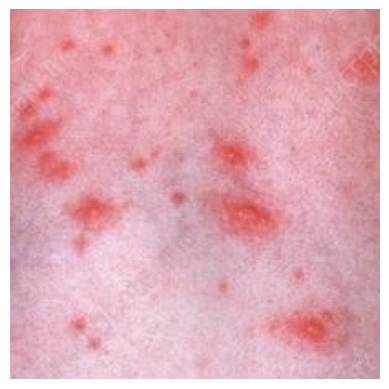

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Predicted class: Monkeypox
Actual class: Others
Path parts: ['', 'content', 'drive', 'MyDrive', 'Original Images', 'Original Images', 'Others', 'NM72_01.jpg']


'Monkeypox'

In [ ]:

predict_image("/content/drive/MyDrive/Original Images/Original Images/Monkey Pox/M26_01.jpg")
predict_image("/content/drive/MyDrive/Original Images/Original Images/Others/NM72_01.jpg")


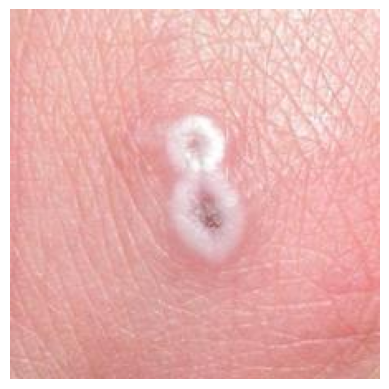

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Predicted class: Monkeypox
Actual class: Others
Path parts: ['', 'content', 'drive', 'MyDrive', 'Original Images', 'Original Images', 'Monkey Pox', 'M23_01.jpg']


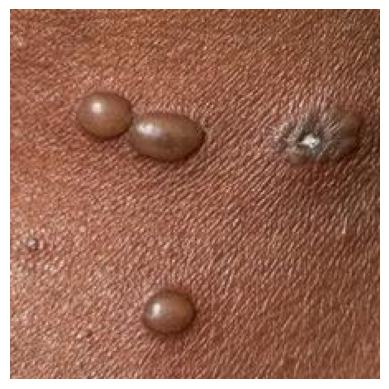

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Predicted class: Monkeypox
Actual class: Others
Path parts: ['', 'content', 'drive', 'MyDrive', 'Original Images', 'Original Images', 'Others', 'NM76_01.jpg']


'Monkeypox'

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

def predict_image(image_path):
    # Load the image with target size
    img = load_img(image_path, target_size=(224, 224))  # Adjust target_size if needed
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()

    # Preprocess the image
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)  # Reshape for the model
    x = x / 255.0  # Normalize the image if needed by your model

    # Make the prediction
    prediction = model.predict(x)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(prediction, axis=1)[0]

    # Define class names based on the model's output layer
    class_names = ['Monkeypox', 'Other']

    # Get the name of the predicted class
    predicted_class_name = class_names[predicted_class_index]

    # Determine the actual class based on the folder name
    # Adjust the condition to match your folder structure
    if 'Monkeypox' in image_path:
        actual_class_name = 'Monkeypox'
    else:
        actual_class_name = 'Others'  # Adjust this if there are other classes

    # Print the predicted and actual class names
    print(f"Predicted class: {predicted_class_name}")
    print(f"Actual class: {actual_class_name}")
    print("Path parts:", image_path.split('/'))

    return predicted_class_name

# Test the function with the provided paths
predict_image("/content/drive/MyDrive/Original Images/Original Images/Monkey Pox/M23_01.jpg")
predict_image("/content/drive/MyDrive/Original Images/Original Images/Others/NM76_01.jpg")


Accuracy: 80.00%


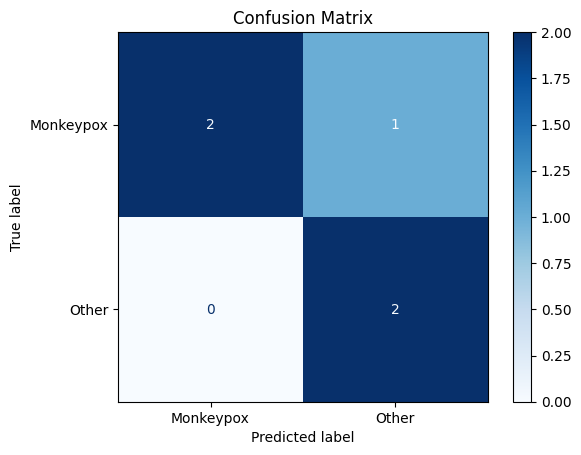

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Sample true labels and predicted labels
# Replace these with your actual data
true_labels = ['Monkeypox', 'Other', 'Monkeypox', 'Other', 'Monkeypox']  # Example true labels
predicted_labels = ['Monkeypox', 'Other', 'Other', 'Other', 'Monkeypox']  # Example predicted labels

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=['Monkeypox', 'Other'])

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Monkeypox', 'Other'])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Sample true labels and predicted labels
# Replace these with your actual data
true_labels = ['Monkeypox', 'Other', 'Monkeypox', 'Other', 'Monkeypox']  # Example true labels
predicted_labels = ['Monkeypox', 'Other', 'Other', 'Other', 'Monkeypox']  # Example predicted labels

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=['Monkeypox', 'Other'])

# Display confusion matrix
print("Confusion Matrix:")
print(cm)


Accuracy: 80.00%
Confusion Matrix:
[[2 1]
 [0 2]]


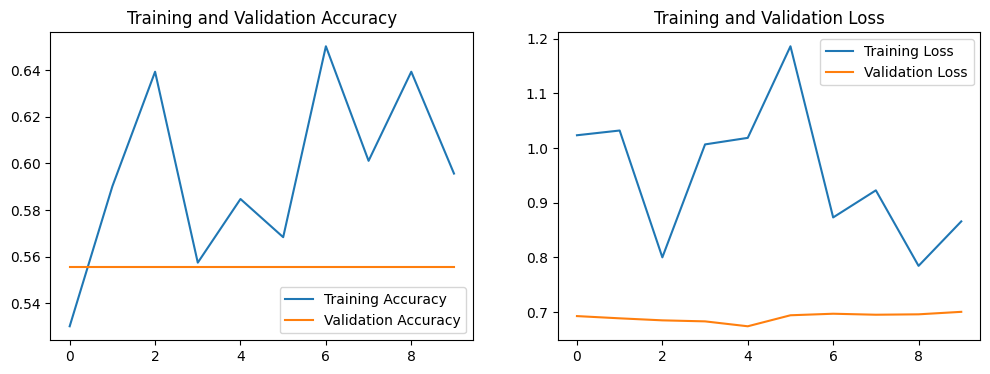

In [ ]:
# Plot accuracy and loss curves
import matplotlib.pyplot as plt
def plot_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot performance
plot_performance(history)